# __Natural Scenes (Intel Dataset) Classification advanced CNN (Convolution Neural Network) techniques like ResNet9 and Resnet18 (Residual Networks) Architectures.__

> First let's import necessary libraries that will be use in this project

In [1]:
import os
import torch
import torchvision
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib
import matplotlib.pyplot as plt
import torchvision.transforms as tt
from torchvision.datasets import ImageFolder
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torchvision.utils import make_grid

%matplotlib inline  

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [2]:
torch.cuda.empty_cache()

> Firstly we have to download the data using kaggle API...

In [59]:
""" import opendatasets as od
dataset_url = "https://www.kaggle.com/datasets/puneet6060/intel-image-classification"
od.download(dataset_url, data_dir="Natural_Scenes_Intel") """

' import opendatasets as od\ndataset_url = "https://www.kaggle.com/datasets/puneet6060/intel-image-classification"\nod.download(dataset_url, data_dir="Natural_Scenes_Intel") '

> Let's check the downloaded data and the classes of the data

In [3]:
import os 
# Setting the data directory where the dataset is downloaded
data_dir ="Natural_Scenes_Intel"
# List all files in the dataset directory
print(os.listdir(data_dir))
classes = os.listdir(data_dir + '/intel-image-classification/seg_train/seg_train')
print(classes)

['intel-image-classification']
['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


> Let's now see the length of all the directories i.e., seg_pred, seg_test and seg_train

In [4]:
train_dataset = torchvision.datasets.ImageFolder(root=data_dir + '/intel-image-classification/seg_train/seg_train')
test_dataset = torchvision.datasets.ImageFolder(root=data_dir + '/intel-image-classification/seg_test/seg_test')
f"Size of Training dataset : {len(train_dataset)} and Size of Test Dataset: {len(test_dataset)}"    

'Size of Training dataset : 14034 and Size of Test Dataset: 3000'

> Transformation of the data using the three Techniques for efficient training:-
### Data Augmentation Techniques
1. Using the Test set for Vaidation
2. Channel-Wise Data Normalization (Using statistics mean and standard deviation) to normalize in the range of (0,1)
3. Randomized Data Augmenttaion
4. ToTensor() 
and more

In [5]:
# Definining the stats for nirmalization
stats = ((0.4580, 0.4340, 0.4080), (0.2292, 0.2215, 0.2231))
# Defining the transforms for training
train_tfms = tt.Compose([
                        tt.Resize((150,150)),
                        tt.RandomCrop(130, padding=2, padding_mode='reflect'),
                         tt.RandomHorizontalFlip(),
                         tt.RandomRotation(degrees=10),
                         tt.ToTensor(),
                         tt.Normalize(*stats, inplace = True)
                         ])

# Defining the transforms for validation and test
val_tfms = tt.Compose([
                        tt.Resize((150,150)),
                        tt.CenterCrop(130),
                        tt.ToTensor(),
                        tt.Normalize(*stats)])

> PyTorch Datasets.../

In [6]:
train_ds = ImageFolder(root=data_dir + '/intel-image-classification/seg_train/seg_train', transform=train_tfms)
val_ds = ImageFolder(root=data_dir + '/intel-image-classification/seg_test/seg_test', transform=val_tfms)

In [7]:
for i in range(10):
    img, label = val_ds[i]
    print(img.shape)  # should print torch.Size([3, 130, 130]) after RandomCrop(130)


torch.Size([3, 130, 130])
torch.Size([3, 130, 130])
torch.Size([3, 130, 130])
torch.Size([3, 130, 130])
torch.Size([3, 130, 130])
torch.Size([3, 130, 130])
torch.Size([3, 130, 130])
torch.Size([3, 130, 130])
torch.Size([3, 130, 130])
torch.Size([3, 130, 130])


In [8]:
#Defining the batch size
batch_size = 64

> PyTorch DataLoaders.../

In [9]:
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=3, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size=batch_size*2, num_workers=3, pin_memory=True)

> Let's view some of the images from our training data
1. De-Normalize the data for viewing the images. (-1,1) --> (0,1)

In [10]:
#Denormalize = Reverse the normalization process
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1,3,1,1)
    stds = torch.tensor(stds).reshape(1,3,1,1)
    return images * stds + means

# Show a batch of images
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1,2,0).clamp(0,1))
        break

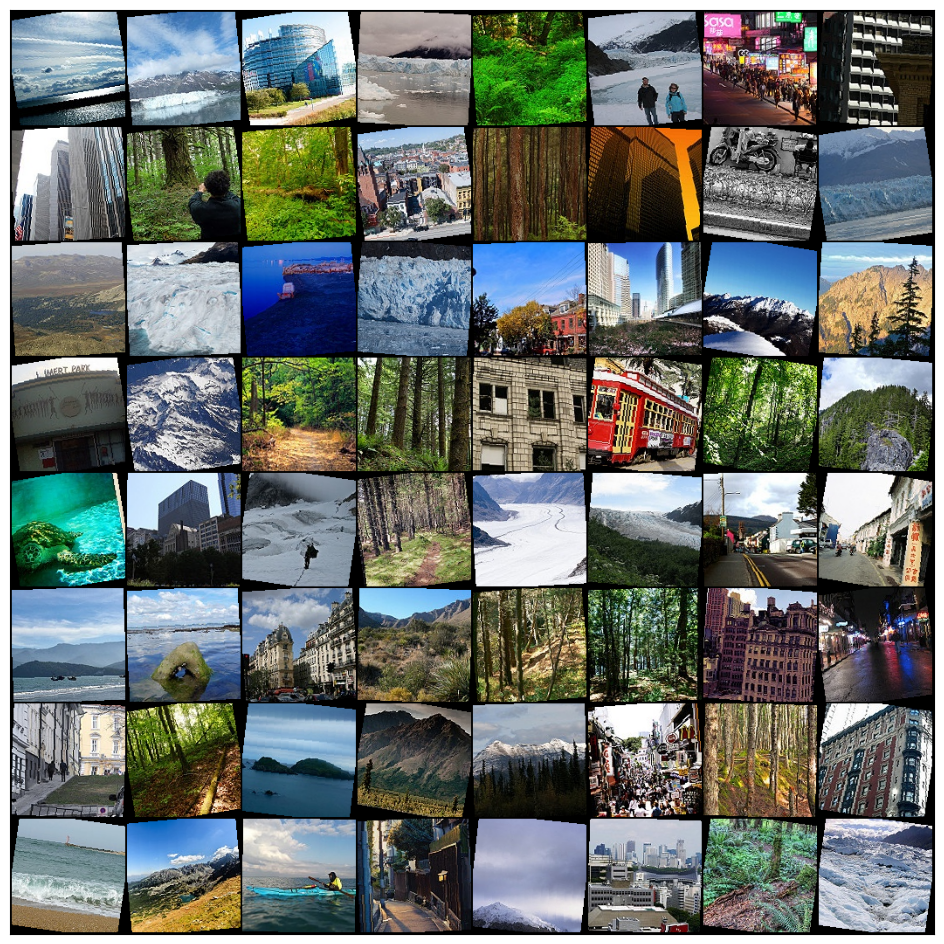

In [11]:
show_batch(train_dl)

> Now let's create some helper functions for training our model on a GPU !

In [12]:
#1. get_dedault_device --> For selecting the device (GPU or CPU) for tensor operations
def get_default_device():
    """Pick GPU if available, else CPU"""
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

#2. to_device --> For moving tensors to the chosen device
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [13]:
# Defining the custom class
class DeviceDataLoader:
    """Wraps a DataLoader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield data after moving it to the device"""
        for data in self.dl:
            yield to_device(data, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [14]:
# Check for the device
device = get_default_device()
device

device(type='cuda')

> So we have the GPU (cuda) for our model training.

> Now we can wrap up our dataloaders into our GPU

In [15]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

### __Simple Residual Network Design.../__

> Let's define the simple Residual Network Block..

In [16]:
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()


    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out) + x

In [17]:
simple_resnet = to_device(SimpleResidualBlock(), device)

for images, labels in train_dl:
    print(images.shape)
    out = simple_resnet(images)
    print(out.shape)
    break

del simple_resnet, images, labels
torch.cuda.empty_cache()

torch.Size([64, 3, 130, 130])
torch.Size([64, 3, 130, 130])


> Now Let's define some more helper classes and Evaluation metric, here __Accuracy__ and __ImageClassificationBase__ class (used in almost all CV models).

In [18]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        batch = to_device(batch, device)
        images, labels = batch
        images, labels = images.to(device), labels.to(device)
        out = self(images) # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        batch = to_device(batch, device)
        images, labels = batch
        images, labels = images.to(device), labels.to(device)
        out = self(images) # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        acc = accuracy(out, labels) # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1],result['train_loss'],result['val_loss'],result['val_acc']
        ))

### __Residual Network 9 Model Architecture Design.../__

In [19]:
# Defining the Helper function for our ResNet9 Model
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(3)) # 3 Pooling layers
    return nn.Sequential(*layers)


# Defining the ResNet9 Model through Custom class
class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        # 3 x 130 x 130 
        self.conv1 = conv_block(in_channels=3, out_channels=64)  # 64 x 130 x 130
        self.conv2 = conv_block(in_channels=64, out_channels=128, pool=True) # 128 x 43 x 43   
        self.res1 = nn.Sequential(conv_block(in_channels=128, out_channels=128),    # 1st Residual Block
                                  conv_block(in_channels=128, out_channels=128)) # 128 x 65 x 65  
        
        self.conv3 = conv_block(in_channels=128, out_channels=256, pool=True) # 256 x 14 x 14 
        self.conv4 = conv_block(in_channels=256, out_channels=512, pool=True) # 512 x 4 x 4
        self.res2 = nn.Sequential(conv_block(in_channels=512, out_channels=512),  # 2nd Residual Block
                                  conv_block(in_channels=512, out_channels=512)) # 512 x 4 x 4
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4),  # 512 x 4 x 4 --> # 512 x 1 x 1
                                        nn.Flatten(),      # 512
                                        nn.Dropout(0.2), # p=0.2 About 20% of the random neurons will be set to zero
                                        nn.Linear(512, num_classes)) # 6
  
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out 

In [20]:
# Checking the device
device

device(type='cuda')

In [21]:
# Transfering the model to the device
model = ResNet9(in_channels=3, num_classes=6)
model.to(device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

### __Training the ResNet9 Model >>>>__
Using some of the efficient techniques like:-
1. Learning Rate Scheudling--> 'One Cycle Learning Rate Policy'
2. Weight Decay --> Regularization Technique --> Adding Additional term to the Loss Function. 
3. Gradient Clipping --> Limit value of gradients to a small values


> For incorporating these things, let's define the __fit_one_cycle()__ function..

In [22]:
@torch.no_grad() # No need to track gradients for validation
def evaluate(model, val_loader):
    model.eval()  # Telling the model to evaluation mode and not traning, also for Batch Normalization and Dropout layers
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    
def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0, grad_clip=None, 
                  opt_func=torch.optim.SGD):
    torch.cuda.empty_cache() # Remove any cached memory from the GPU or Remove existing tensoors not use in GPU
    history=[]

    # Custom Optimizer
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # One Cycle Learning Rate Scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                    steps_per_epoch=len(train_loader))
    

    for epoch in range(epochs):
        #Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            #Gradient Clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad() # Zero the gradients after each step

            # record the learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation Phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [23]:
history = [evaluate(model, val_dl)]
history

[{'val_loss': 1.8031666278839111, 'val_acc': 0.1673177033662796}]

> ### __Training our Model>>>__

In [24]:
# Defining the hyperparameters for function training.
epochs = 10
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam # taking the Adam optimization function instead of SGD(Stochastic Gradient Descent)

In [53]:
%%time
import time
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, grad_clip=grad_clip, weight_decay=weight_decay, opt_func=opt_func)

Epoch [0], last_lr: 0.00279, train_loss: 0.9238, val_loss: 0.974220, val_acc: 0.6562
Epoch [1], last_lr: 0.00759, train_loss: 0.7602, val_loss: 1.758115, val_acc: 0.5430
Epoch [2], last_lr: 0.01000, train_loss: 0.7396, val_loss: 0.604200, val_acc: 0.7857
Epoch [3], last_lr: 0.00950, train_loss: 0.5792, val_loss: 0.598407, val_acc: 0.7891
Epoch [4], last_lr: 0.00812, train_loss: 0.5072, val_loss: 0.559200, val_acc: 0.7889
Epoch [5], last_lr: 0.00611, train_loss: 0.4614, val_loss: 0.566816, val_acc: 0.7823
Epoch [6], last_lr: 0.00389, train_loss: 0.4077, val_loss: 0.434774, val_acc: 0.8500
Epoch [7], last_lr: 0.00188, train_loss: 0.3480, val_loss: 0.387065, val_acc: 0.8564
Epoch [8], last_lr: 0.00050, train_loss: 0.2954, val_loss: 0.282641, val_acc: 0.9007
Epoch [9], last_lr: 0.00000, train_loss: 0.2552, val_loss: 0.277726, val_acc: 0.9027
CPU times: total: 9min 41s
Wall time: 2h 27min 44s


> ### __So our Validation Accuracy is 90.27%__ __Good!!__


> ### Now Let's Plot Evaluation Metric, Epochs wise Performance, and Learning rate Curve..

In [56]:
# Defining the function to plot the loss and accuracy
def plot_accuracies(history):
    plt.plot([x['val_acc'] for x in history], '-o', label='val_acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Validation Accuracy vs Epochs')

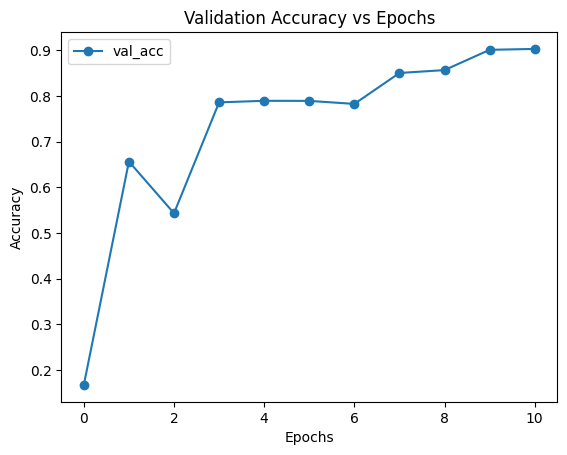

In [57]:
plot_accuracies(history)

In [60]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x.get('val_loss') for x in history]
    plt.plot(train_losses, '-o', label='train_loss')
    plt.plot(val_losses, '-o', label='val_loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss vs Epochs')

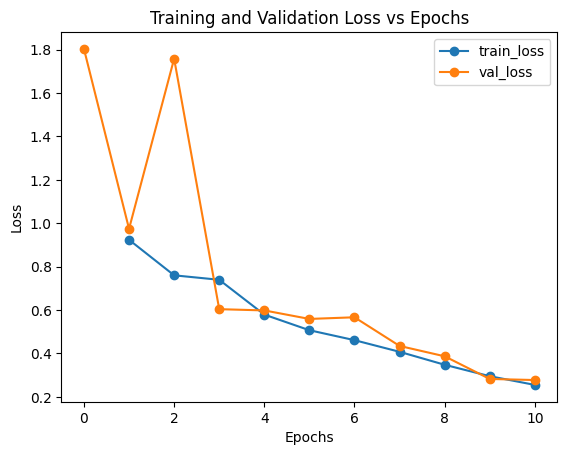

In [61]:
plot_losses(history)

In [64]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch No.')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate vs Batch No.')


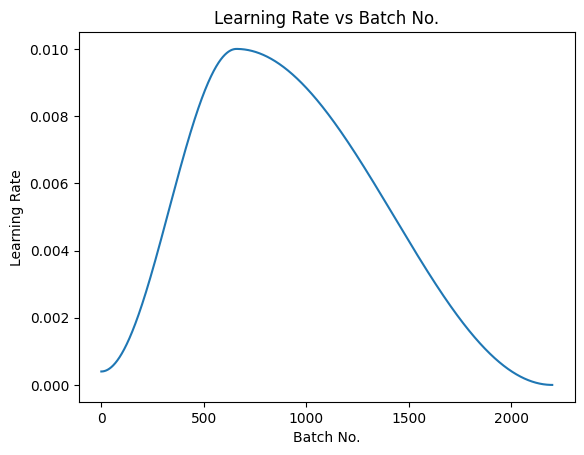

In [65]:
plot_lrs(history)

> ## __Testing the model on Individial Images for Validation>>>__

In [66]:
# Defining the function for testing the images with the trained model
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)  # Add batch dimension and move to device
    yb = model(xb)  # Forward pass
    _, preds = torch.max(yb, dim=1)  # Get the predicted class
    return train_ds.classes[preds[0].item()]  # Return the class name

Label: buildings Predicted: buildings


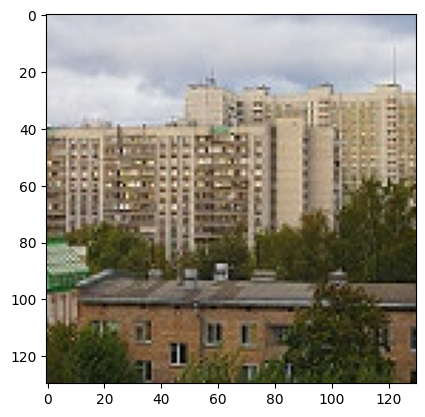

In [89]:
img, label = val_ds[123]
plt.imshow(denormalize(img.unsqueeze(0), *stats).squeeze().permute(1, 2, 0).clamp(0, 1))
print("Label:", train_ds.classes[label], "Predicted:", predict_image(img, model))

Label: street Predicted: street


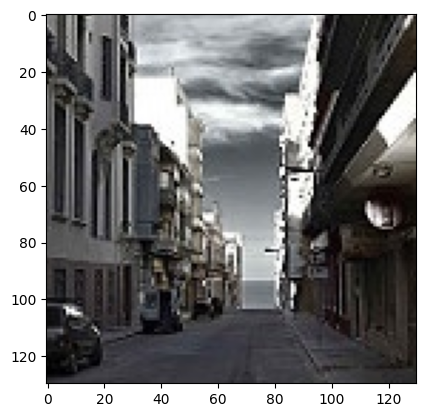

In [92]:
img, label = val_ds[2948]
plt.imshow(denormalize(img.unsqueeze(0), *stats).squeeze().permute(1, 2, 0).clamp(0, 1))
print("Label:", train_ds.classes[label], "Predicted:", predict_image(img, model))

Label: forest Predicted: forest


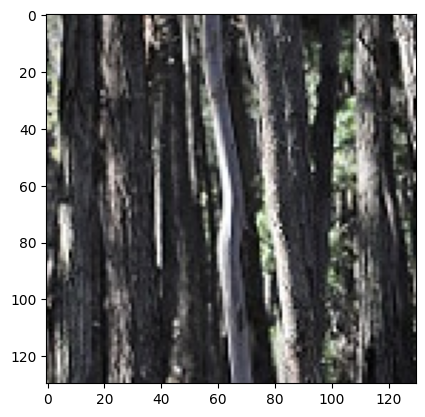

In [93]:
img, label = val_ds[589]
plt.imshow(denormalize(img.unsqueeze(0), *stats).squeeze().permute(1, 2, 0).clamp(0, 1))
print("Label:", train_ds.classes[label], "Predicted:", predict_image(img, model))

> ### __So our Model Classifies the Images Very Well.., So Let's Save and Commit the Model..>>>__

In [97]:
torch.save(model.state_dict(), 'Natural_Scenes_ResNet9_Classifier.pth')

In [96]:
torch.load('Natural_Scenes_ResNet9_Classifier.pth', map_location=device)
model.load_state_dict(torch.load('Natural_Scenes_ResNet9_Classifier.pth', map_location=device))

<All keys matched successfully>

In [98]:
model.state_dict()

OrderedDict([('conv1.0.weight',
              tensor([[[[-0.0041,  0.4124, -0.2971],
                        [-0.0122, -0.0098, -0.0256],
                        [-0.3375,  0.0992,  0.0711]],
              
                       [[-0.1524,  0.3739, -0.2650],
                        [ 0.0543,  0.2015,  0.0346],
                        [-0.1520,  0.2149, -0.0602]],
              
                       [[-0.2340,  0.1525, -0.4085],
                        [ 0.1520, -0.1409, -0.0816],
                        [ 0.0101,  0.2671,  0.1883]]],
              
              
                      [[[ 0.0299, -0.0964, -0.1581],
                        [-0.3652, -0.0783,  0.0305],
                        [ 0.0371, -0.0237,  0.3669]],
              
                       [[ 0.2245,  0.0592,  0.0734],
                        [-0.4123,  0.1110,  0.1685],
                        [-0.1094,  0.0291,  0.3973]],
              
                       [[ 0.1980, -0.1365,  0.1533],
                        